**Batter Spray Charts**

This notebook generates a spray chart showing away and home team batting results for a specified game.

The field dimensions are notional becuase every ball park is different and usually not symetric.

In [29]:
# load some modules and setup constants

import requests
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import path 
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import sys
%matplotlib inline

API_BASE_URL = "http://statsapi.mlb.com/api"
API_PLAYBYPLAY_URL = API_BASE_URL + "/v1/game/{}/playByPlay?fields={}"
API_SCHEDULE_URL = API_BASE_URL + "/v1/schedule?sportId=1&date={}&fields={}"
API_TEAMS_URL = API_BASE_URL + "/v1/teams?sportId=1&activeStatus=ACTIVE&fields={}"

# Team name dictionary
TEAM_NAMES_BY_ABBREV = {}

# setup polygons to represent sectors (pie wedges) of field (thirds)
# assume foul lines = 320 teet (distance between foul poles = 320, ergo the plot width is 320)
# assume outfield wall is 400 feet
# plotting assumes the coordinate represent feet
MAX_Y = 450 # maybe this should be 600ish?
MAX_X = 320
MIN_X = 0
MID_X = (MAX_X - MIN_X) / 2
POLY_LEFT_PTS = [[MID_X,MIN_X], [MIN_X,MAX_X], [MIN_X,MAX_Y], [106,MAX_Y], [160,MIN_X]]
POLY_MIDDLE_PTS = [[MID_X,MIN_X], [106,MAX_Y], [212,MAX_Y], [MID_X,MIN_X]]
POLY_RIGHT_PTS = [[MID_X,MIN_X], [212,MAX_Y], [MAX_X,MAX_Y], [MAX_X,MAX_X], [MID_X,MIN_X]]

Enter the team trigraph and the date of the game to pull the data from MLB and chart it.

In [13]:
# Enter team trigraph and date of game
# ====================================
team = 'LAD'
game_date = '11/01/2017'
# ====================================

The following cell contains utility functions used later to retrieve data and build plots.

In [14]:
# get data from MLB
def get_data(url):
    try:
        results = requests.get(url).json()
        if 'messageNumber' in results:
            print('ERROR:  {} - {}'.format(results['messageNumber'], results['message']))
    except:
        print('An unhandled exception occurred retrieving data from MLB.\n')
    return results

# load the MLB team names into a dictionary (tri_graph: team_name)
def load_teams():
    fields = 'teams,0,id,name,abbreviation'
    teams = get_data(API_TEAMS_URL.format(fields))['teams']

    # load dictionaries using specific attributes of teams
    for team in teams:
        TEAM_NAMES_BY_ABBREV.update({team['abbreviation']: team['name']})

    return

# find the game key based upon the team playing and the date.  The game key is required
# for all MLB API calls.
def find_gamepk(team, game_date):
    game_pk = 0  # no game today
    away_team = ''
    home_team = ''
    
    try:
        # validate team names
        if team in TEAM_NAMES_BY_ABBREV.keys():
            fields = 'dates,games,gamePk,teams,team,name,gameNumber'
            schedule = get_data(API_SCHEDULE_URL.format(game_date, fields))

            # loop through games looking for team
            for games in schedule['dates'][0]['games']:

                if games['teams']['away']['team']['name'] == TEAM_NAMES_BY_ABBREV[team]: 
                    game_pk = games['gamePk']
                    away_team = games['teams']['away']['team']['name']
                    home_team = games['teams']['home']['team']['name']
                    break
                elif games['teams']['home']['team']['name'] == TEAM_NAMES_BY_ABBREV[team]:
                    game_pk = games['gamePk']
                    away_team = games['teams']['away']['team']['name']
                    home_team = games['teams']['home']['team']['name']   
                    break
    except:
        game_pk = 0  # no game found
    return game_pk, away_team, home_team

The following cell retrieves the batting data for a game using the MLB API.  Only the data required for building the spray charts are retrieved (specified in the _field_ variable).  Data is returned for hits and outs.

In [15]:
def get_hit_data(game_pk):
    
    fields = "allPlays,result,event,about,halfInning,playEvents,hitData,location,coordinates,totalDistance"
    data = get_data(API_PLAYBYPLAY_URL.format(game_pk, fields))

    # Process batting data
    hit_data_tuple = []
    out_data_tuple = []
    for n in range(len(data['allPlays'])):
        #print('n=',n)
        play = data['allPlays'][n]
        #print('play=',play)
        inning_half = play['about']['halfInning']
        #print(inning_half)
        
        hit_result = play['result']['event']
        #print('hit result',hit_result)
        
        
        m = len(play['playEvents']) -1
        #print('m=',m)
        event = play['playEvents'][m]
        #print('event=',event)

        if 'hitData' in event.keys():
            location = int(event['hitData']['location'])
            x = event['hitData']['coordinates']['coordX']
            y = event['hitData']['coordinates']['coordY']
            
            if hit_result in ['Single', 'Double', 'Triple', 'Home Run']:
                hit_data_tuple.append((inning_half.upper(), x, y, location, hit_result))
            else:
                out_data_tuple.append((inning_half.upper(), x, y, location, hit_result))
                
    # hit_data = pd.DataFrame(data=hit_data_tuple, columns=['inning_half', 'x', 'y', 'location', 'play_result'])
    #print(hit_data.head(30))
    # out_data = pd.DataFrame(data=out_data_tuple, columns=['inning_half', 'x', 'y', 'location', 'play_result'])
    #print(out_data.head(30))
    return hit_data_tuple, out_data_tuple

The following function draws the baseball field and the three pie wedges.

In [25]:
def draw_field(team):
    
    fig, ax = plt.subplots(1,1)  # set figure aspect/size?
    fig.suptitle('Batting results for {} - {}'.format(team, game_date), fontsize=20)
    ax.set_xlim(0, MAX_X)
    ax.set_ylim(0, MAX_Y)
    #ax.set_xticks(())
    #ax.set_yticks(())
    
    # draw outfield arc
    ax.add_patch(mpatches.Arc([160,200], 300, MAX_Y, angle=0, theta1=28, theta2=152))
    
    # draw infield arc
    ax.add_patch(mpatches.Arc([160,0], 120, 300, angle=0, theta1=63, theta2=117))
      
    # draw sector bounding lines
    px = [x[0] for x in POLY_LEFT_PTS]
    py = [y[1] for y in POLY_LEFT_PTS]
    ax.plot(px, py, color='black', linestyle='-', linewidth=1)
    
    px = [x[0] for x in POLY_MIDDLE_PTS]
    py = [y[1] for y in POLY_MIDDLE_PTS]
    ax.plot(px, py, color='black', linestyle='-', linewidth=1)
    
    px = [x[0] for x in POLY_RIGHT_PTS]
    py = [y[1] for y in POLY_RIGHT_PTS]
    ax.plot(px, py, color='black', linestyle='-', linewidth=1)
    
    return ax

This function plots the hits and outs for the given team.

In [23]:
def plot_hits(inning_half, team, hit_data_tuple, out_data_tuple):
    
    # draw field boundaries and sectors
    ax = draw_field(team)
    
    # build polygons of sectors to check each hit coords
    poly_left = path.Path(POLY_LEFT_PTS)
    poly_middle = path.Path(POLY_MIDDLE_PTS)
    poly_right = path.Path(POLY_RIGHT_PTS)
    
    # put hit coordinates in list based upon inclusion in sector polys
    left_hit = [[x[1], 400-x[2], x[4]] for x in hit_data_tuple if poly_left.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('left=',left_hit)
    middle_hit = [[x[1], 400-x[2], x[4]] for x in hit_data_tuple if poly_middle.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('middle=',middle_hit)
    right_hit = [[x[1], 400-x[2], x[4]] for x in hit_data_tuple if poly_right.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('right=',right_hit)
    
    # plot hits
    # left
    left_x = [x[0] for x in left_hit]
    left_y = [y[1] for y in left_hit]
    # right
    right_x = [x[0] for x in right_hit]
    right_y = [y[1] for y in right_hit]
    # middle
    mid_x = [x[0] for x in middle_hit]
    mid_y = [y[1] for y in middle_hit]
    
    ax.scatter(left_x + mid_x + right_x, left_y + mid_y + right_y, color='blue', label='Hit')
    
    # put out coordinates in list based upon inclusion in sector polys
    left_out = [[x[1], 400-x[2], x[4]] for x in out_data_tuple if poly_left.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('left=',left_out)
    middle_out = [[x[1], 400-x[2], x[4]] for x in out_data_tuple if poly_middle.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('middle=',middle_out)
    right_out = [[x[1], 400-x[2], x[4]] for x in out_data_tuple if poly_right.contains_point([x[1],400-x[2]]) and inning_half == x[0]]
    #print('right=',right_out)
    
    # plot outs
    # left
    left_x = [x[0] for x in left_out]
    left_y = [y[1] for y in left_out]
    # right
    right_x = [x[0] for x in right_out]
    right_y = [y[1] for y in right_out]
    # middle
    mid_x = [x[0] for x in middle_out]
    mid_y = [y[1] for y in middle_out]
    
    #ax.scatter(left_x + mid_x + right_x, left_y + mid_y + right_y, color='red', label='Out', marker='x')
    
    ax.legend()
    plt.show();
    

The is the main body of the code.  This code loads the team name dictionary, finds the game key and formal team names, retrieves the batting data from MLB, and plots the hit results for the away and home team.

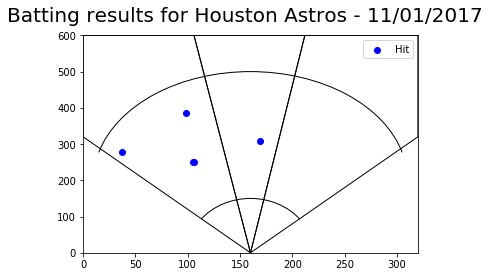

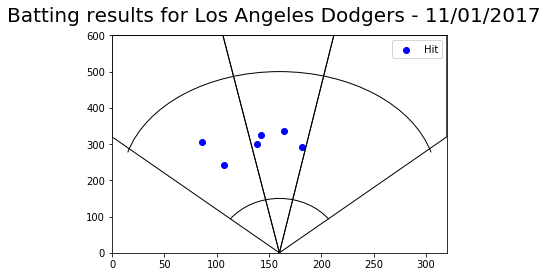

In [28]:
# ===== MAIN =====

# load team names and abbrev
load_teams()

# Get game PK
game_pk, away_team, home_team = find_gamepk(team, game_date)

# Retrieve hit data
if game_pk > 0:
    hit_data, out_data = get_hit_data(game_pk)
    
    # Plot the pitch data
    plot_hits('TOP', away_team, hit_data, out_data)
    plot_hits('BOTTOM', home_team, hit_data, out_data)
    
else:
    print("No game found for {} on {}".format(team, game_date))
    print(TEAM_NAMES_BY_ABBREV)